In [4]:
#import packages to do EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
%matplotlib inline

import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.io as pio
pio.renderers.default='notebook'
plt.style.use('fivethirtyeight')



import gc

# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
import matplotlib.font_manager


from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.sparse import coo_matrix,hstack,vstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import lightgbm as lgbm
import pickle


#DecisionTree with hyper paramenter tuning.
#reference:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold
from scipy.stats import randint as sp_randint
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.metrics import log_loss
import optuna

#from hyperopt import hp, fmin,tpe, Trials
from sklearn import metrics
from sklearn import ensemble
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import pipeline

#### Read vector from pickle file

In [5]:
with open('./data/train_vector.pkl', 'rb') as f:
    X = pickle.load(f)

In [6]:
with open('./data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

In [7]:
print(X.shape[1],len(feature_names))

1037 1037


In [8]:
with open('./data/yvalues.pkl', 'rb') as f:
    y = pickle.load(f)

##### testing purpose only
'''
traindata=20000
X = X.tocsr()[:traindata,:]
y=y[:traindata]
print(X.shape,y.shape)
'''

#### Model Evaluation

#### Hyper parameter tuning for ensemble models

In [9]:
#split data only train and test. 
#Hypertuning with gridsearch and random 
#hypertuning, will do automatic cv. Hence, split data into Train and Test only. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42)

In [8]:
#credit:https://www.kaggle.com/saurabhshahane/lgbm-hyperparameter-tuning-with-optuna-beginners
#credit:https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

def optimize_rf(x,y):    
    clf = ensemble.RandomForestClassifier(n_jobs=-1)
    
    #default method = Random
    param_grid = {
                  "n_estimators": [200,300,400,500],
                  "max_depth": [3,5,7],
                  "criterion":['gini','entropy'],
                 }
    model = model_selection.GridSearchCV(
            estimator=clf, param_grid=param_grid,scoring='roc_auc',
            verbose=0,cv=3, n_jobs=1, return_train_score=True)
    model.fit(X=x,y=y)
    results = pd.DataFrame.from_dict(model.cv_results_)
    return results, model
results_rf,model_rf = optimize_rf(x=X_train,y=y_train)

In [9]:
#function to plot heatmap
def plot_heatmap(results):
    plt.close()
    results = results.sort_values(['param_n_estimators'])
    results = results[['param_n_estimators', 'param_max_depth','mean_test_score', 'mean_train_score']]
    #get only n estimators and max depth only 
    max_scores = results.groupby(['param_n_estimators', 'param_max_depth']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    plt.figure(figsize=(15, 10))
    ax_tr = plt.subplot(221)
    plt.title("Heatmap on Train data")
    sns.heatmap(max_scores['mean_train_score'], ax=ax_tr, fmt='.2f',cmap='YlGnBu',annot=True)
    ax_tr.set_xlabel('max_depth')
    ax_tr.set_ylabel('n_estimators')

    ax_cv = plt.subplot(222)
    plt.title("Heatmap on CV data")
    sns.heatmap(max_scores['mean_test_score'], ax=ax_cv, fmt='.2f',cmap='YlGnBu',annot=True)
    ax_cv.set_xlabel('max_depth')
    ax_cv.set_ylabel('n_estimators')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)    
    plt.show();
    return

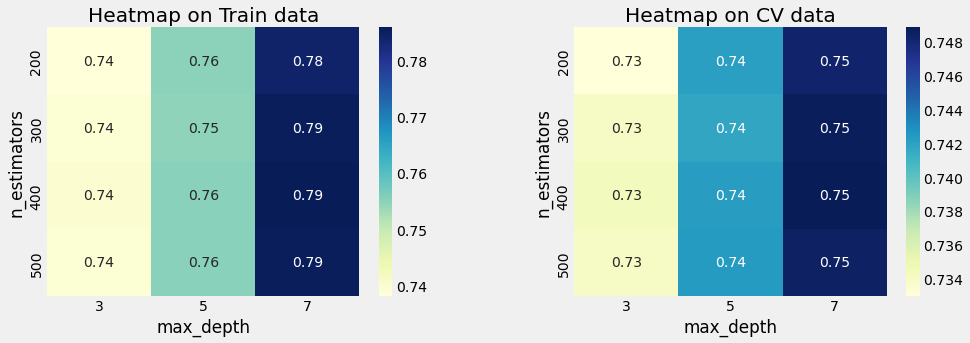

In [10]:
plot_heatmap(results_rf)

In [11]:
model_rf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=400,
                       n_jobs=-1)

In [21]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def plot_confusionmatrix(y_tr,y_trpred,y_te,y_tepred):
    from sklearn.metrics import confusion_matrix
    
    tn, fp, fn, tp = confusion_matrix(y_tr, np.round(y_trpred)).ravel()    
    #print('Training data tn-> {}, fp-> {}, fn-> {}, tp-> {}'.format(tn, fp, fn, tp), end=" ")
    #confusion matrix on training data 
    plt.figure(figsize=(10, 10))
    ax_tr = plt.subplot(221)
    cm_tr = confusion_matrix(y_tr, np.round(y_trpred))
    plt.title("Training data - Confusion Matrix")
    sns.heatmap(cm_tr, ax=ax_tr, fmt='d',cmap='YlGnBu',annot=True)
    # labels, title and ticks
    ax_tr.set_xlabel('Predicted labels');
    ax_tr.set_ylabel('True labels'); 
    ax_tr.set_ylim(2.0, 0)
    ax_tr.xaxis.set_ticklabels(['No','Yes']); 
    ax_tr.yaxis.set_ticklabels(['No','Yes']);
    
    #Confusion matrix on test data
    tn, fp, fn, tp = confusion_matrix(y_te, np.round(y_tepred)).ravel()    
    #print('Testing data tn-> {}, fp-> {}, fn-> {}, tp-> {}'.format(tn, fp, fn, tp), end=" ")
    
    ax_te = plt.subplot(222)
    cm_te = confusion_matrix(y_te, np.round(y_tepred))
    plt.title("Test data - Confusion Matrix")
    sns.heatmap(cm_te, ax=ax_te, fmt='d',cmap='YlGnBu',annot=True)
    # labels, title and ticks
    ax_te.set_xlabel('Predicted labels');
    ax_te.set_ylabel('True labels'); 
    ax_te.set_ylim(2.0, 0)
    ax_te.xaxis.set_ticklabels(['No','Yes']); 
    ax_te.yaxis.set_ticklabels(['No','Yes']);

    plt.show()
    return

In [11]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    return y_data_pred

In [22]:
def draw_roccurve(y_tr,y_tr_pred,y_te,y_te_pred):
    #fpr,tpr,thresholds 
    fpr, tpr, thresholds = roc_curve(y_tr, np.array(y_tr_pred))
    #auc score train score
    auc_train = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=" AUC train ="+str(np.round(auc_train,4)))
    plt.plot([0, 1], [0, 1],'r--')
    
    fpr, tpr, thresholds = roc_curve(y_te, np.array(y_te_pred))
    #auc score test score
    auc_test = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=" AUC test ="+str(np.round(auc_test,4)))
    plt.plot([0, 1], [0, 1],'b--')
    
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC" )
    plt.grid()
    plt.show()
    return auc_train,auc_test

In [13]:
from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
#class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))) 
#y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5439099467262235, 1: 6.193470811038297}

In [25]:
#based on the best parameters, predict values and plot AUC  and return the model
def measure_accuracy(X_tr,X_te,y_tr,y_te):
    clf =ensemble.RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=400,
                       n_jobs=-1,class_weight=d_class_weights,min_samples_split=3)
    
    #clf = ensemble.RandomForestClassifier(**best_model.best_params_, min_samples_split=3,n_jobs=-1)
    clf.fit(X_tr, y_tr)

    y_tr_pred = batch_predict(clf, X_tr)    
    y_te_pred = batch_predict(clf, X_te)

    plot_confusionmatrix(y_tr,y_tr_pred,y_te,y_te_pred)
    print('='*70)
    auc_train,auc_test=draw_roccurve(y_tr,y_tr_pred,y_te,y_te_pred)
    print('='*70)
    return clf, auc_train,auc_test

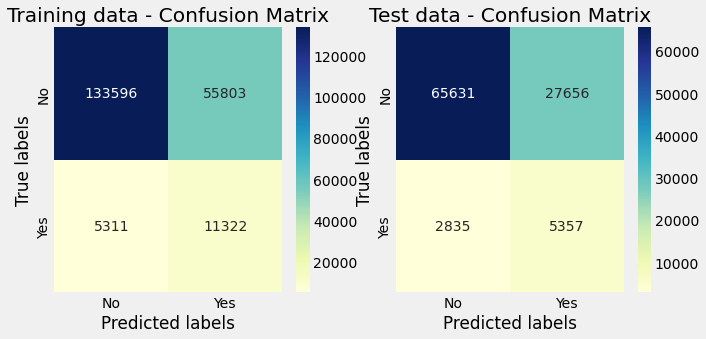

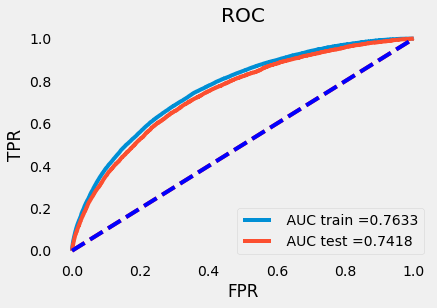

In [26]:
#measure accuracy hypertuned with RandomSearch
#rf_model,auc_tr_rf_model,auc_te_rf_model = measure_accuracy(model_rf,X_train,X_test,y_train,y_test)
rf_model,auc_tr_rf_model,auc_te_rf_model = measure_accuracy(X_train,X_test,y_train,y_test)

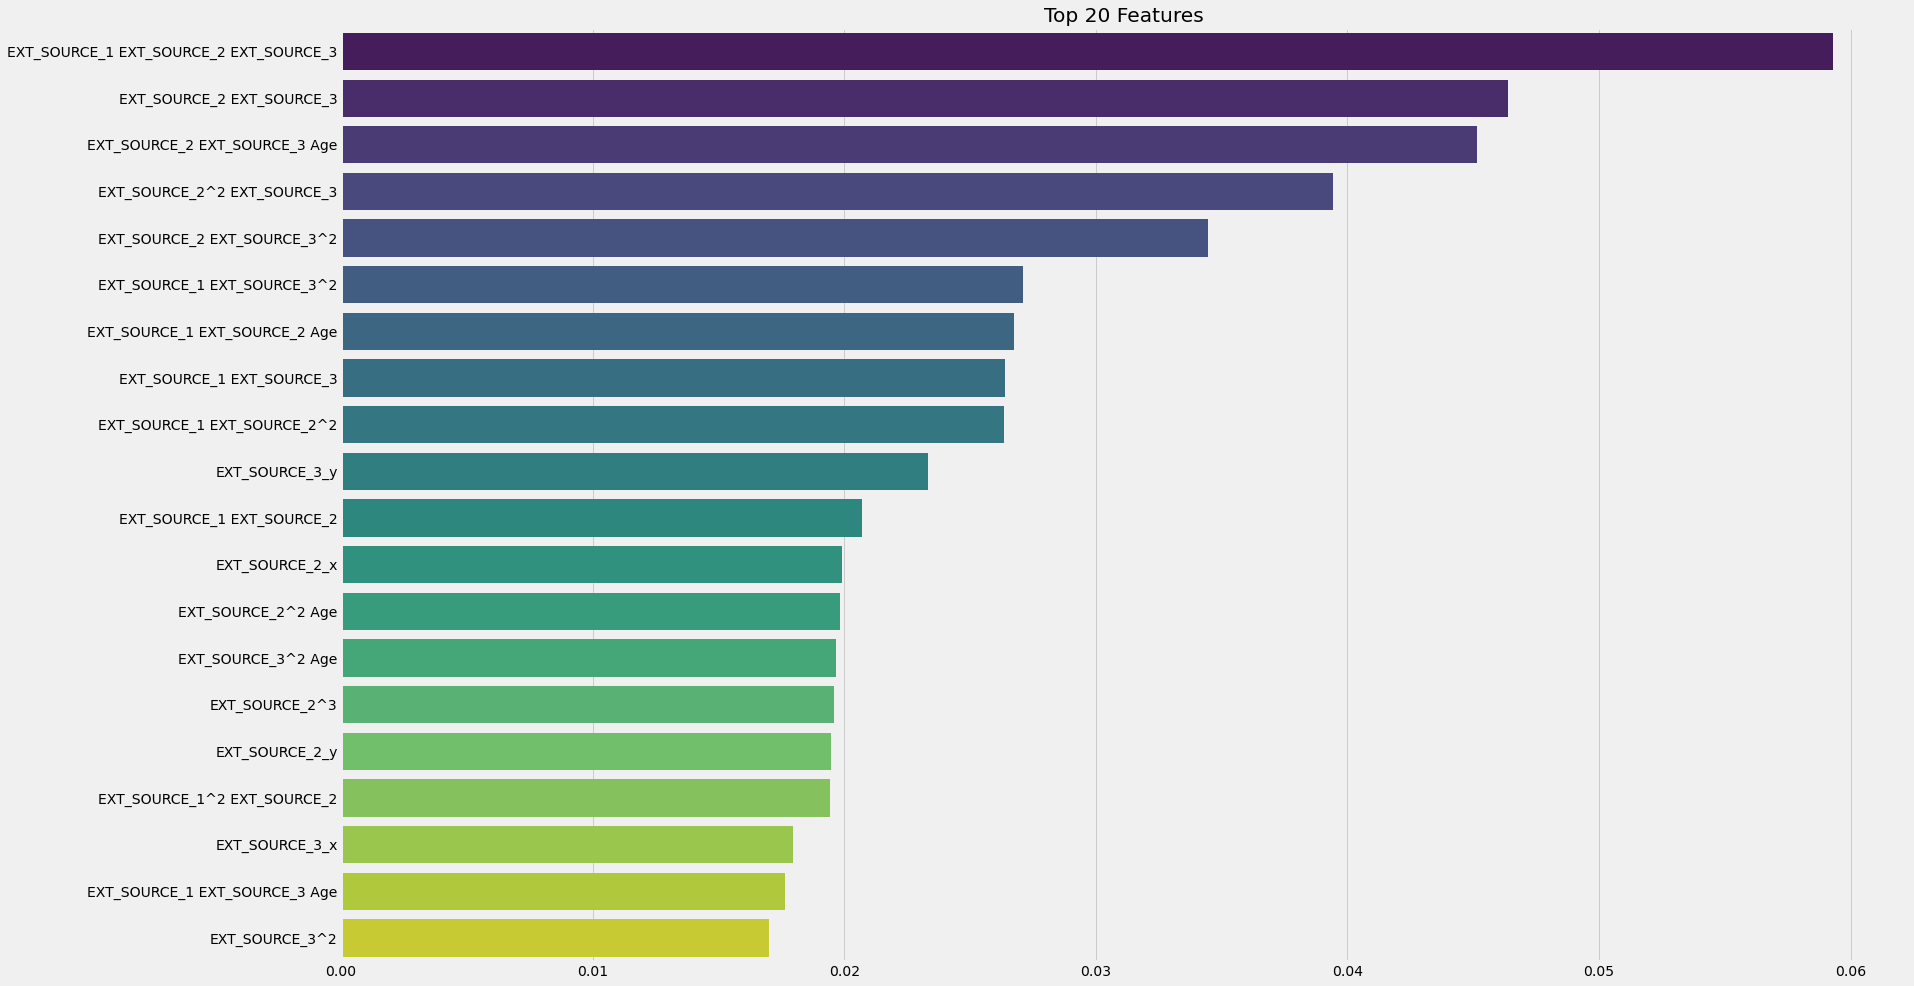

In [29]:
top20_feature_names=[]
feature_importance = rf_model.feature_importances_
indices = feature_importance.argsort()[::-1][:20]
for i in indices:
    top20_feature_names.append(feature_names[i])

#Plot bar plot for top 15 features
plt.close()
column =top20_feature_names
score = feature_importance[indices]
plt.figure(figsize =(25, 16))
sns.barplot(y=column, x=score, palette="viridis")
plt.xticks(rotation=0)
plt.title('Top 20 Features')
plt.show()

In [18]:
model_rf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=400,
                       n_jobs=-1)

In [30]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Feature","Score"]
for val in zip(column,score):
    x.add_row([val[0],np.round(val[1],4)])

x.sortby = "Score"
x.align["Feature"] = "l"
x.align["Score"] = "r"

x.reversesort = True
print(x)

+----------------------------------------+--------+
| Feature                                |  Score |
+----------------------------------------+--------+
| EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 | 0.0593 |
| EXT_SOURCE_2 EXT_SOURCE_3              | 0.0464 |
| EXT_SOURCE_2 EXT_SOURCE_3 Age          | 0.0451 |
| EXT_SOURCE_2^2 EXT_SOURCE_3            | 0.0394 |
| EXT_SOURCE_2 EXT_SOURCE_3^2            | 0.0345 |
| EXT_SOURCE_1 EXT_SOURCE_3^2            | 0.0271 |
| EXT_SOURCE_1 EXT_SOURCE_2 Age          | 0.0267 |
| EXT_SOURCE_1 EXT_SOURCE_3              | 0.0264 |
| EXT_SOURCE_1 EXT_SOURCE_2^2            | 0.0263 |
| EXT_SOURCE_3_y                         | 0.0233 |
| EXT_SOURCE_1 EXT_SOURCE_2              | 0.0207 |
| EXT_SOURCE_2_x                         | 0.0199 |
| EXT_SOURCE_2^2 Age                     | 0.0198 |
| EXT_SOURCE_3^2 Age                     | 0.0197 |
| EXT_SOURCE_2^3                         | 0.0196 |
| EXT_SOURCE_2_y                         | 0.0195 |
| EXT_SOURCE